#### Import packages and define functions

In [77]:
import numpy as np
import pandas as pd
import sklearn
import os
import re
import itertools

In [78]:
def bool_to_int(sample, colname):
    def is_yes(a):
        if a == 'Yes':
            return 1
        else:
            return 0
    return sample[colname].apply(is_yes)

#### Load input CPG dataframes

Input dataframes are loaded in added to a dicctionary.

In [79]:
# List to iterate to create dicc dataframe
cancer_files = os.listdir("/home/amaqueda/TFM/ML_project/ML_part/input/",)
cancer_types = [re.sub("_lof.fisher.permutation_input.tsv", "", x) for x in cancer_files]

In [80]:
# Create empty dicc
CPGs_input_dicc = {}
for (name,file) in zip(cancer_types, cancer_files):
    CPGs_input_dicc[name] =  pd.read_table("/home/amaqueda/TFM/ML_project/ML_part/input/" + file, sep="\t", header=0)

#### Test only with Pan-cancer information

1. From the dataframe dicctionary we select the pancancer dataset.
2. Then we set the gene names as dataframe indexes, to later drop that column + CPG related information features.
3. Then pathways features are turned to boolean.


In [159]:
# Select pancancer features and put genes as the index
CPG_input_pancancer = CPGs_input_dicc["PANCANCER"]
CPG_input_pancancer.index = CPG_input_pancancer["Gene"]
# CPG_input_pancancer.info()

# Drop unused features features.
CPG_input_pancancer_ML = CPG_input_pancancer.drop(columns = ["Gene", "PTM.exact_pval", "PTM.proximal_pval", "PTM.distal_pval",
                                                             "PTM_exact_pval_EUR", "PTM_proximal_pval_EUR", "PTM_distal_pval_EUR"])

# Maybe used to change T/F for 1/0, not needed now
 
for col in ["CPG","DNA_repair", "PIK_mTOR", "Cell_cycle", "Chromatin"]: 
    CPG_input_pancancer_ML[col] = bool_to_int(CPG_input_pancancer_ML, col)

# CPG_input_pancancer_ML = CPG_input_pancancer_ML
# CPG_input_pancancer_ML.info()

CPG_input_pancancer_non_redundant = CPG_input_pancancer_ML.drop(columns = [s for s in CPG_input_pancancer_ML.columns if "min" in s] +
                             ["amplification.freq", "deletion.freq"] +
                             ["avg_CPG", "avg_DNA_repair", "avg_PIK_mTOR", "avg_Cell_Cycle", "avg_Chromatin_Remodeling"] +
                             ["DNA_repair", "PIK_mTOR", "Cell_cycle", "Chromatin"] +
                             ["tau_tissue_specificity", "num.PTV_mutations", "interaction_estimate_EUR", "z_value_EUR"] +
                             ["interaction_estimate_loh_germ_glm", "z_value_loh_germ_glm"] +
                             ["oe_lof_upper"] + [s for s in CPG_input_pancancer_ML.columns if "all_types" in s] +
                             ["clinvar.germline.freq", "delmis.germline.freq", "plof.germline.freq",
                              "clinvar.gnomAD_AF", "delmis.gnomAD_AF", "plof.gnomAD_AF"] +
                             [s for s in CPG_input_pancancer_ML.columns if "germline" in s] +
                             [s for s in CPG_input_pancancer_ML.columns if "fish" in s])

CPG_input_pancancer_non_redundant.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18464 entries, A1BG to DUX4L2
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gain+amplification.freq      17633 non-null  float64
 1   loss+deletion.freq           17633 non-null  float64
 2   tau_cancer_type_specificity  16046 non-null  float64
 3   delmis.gnomAD_AF_EUR         17340 non-null  float64
 4   plof.gnomAD_AF_EUR           17340 non-null  float64
 5   clinvar.gnomAD_AF_EUR        17340 non-null  float64
 6   p_value_EUR                  16489 non-null  float64
 7   num.somatic_mutation         17183 non-null  float64
 8   PTV_frequency                17183 non-null  float64
 9   CPG                          18464 non-null  int64  
 10  avg_ALL                      8993 non-null   float64
 11  oe_lof                       16506 non-null  float64
 12  permut_exact_pval            16167 non-null  float64
 13  permut_proximal_p

### NA TO MEANS

In [160]:
distances_cols = [s for s in CPG_input_pancancer_non_redundant.columns if ("avg" in s)|("min" in s)]

In [161]:
cpgs = CPG_input_pancancer_non_redundant[CPG_input_pancancer_non_redundant['CPG'] == 1]
for col in distances_cols:
    cpgs[col].replace(np.nan, cpgs[col].mean(), inplace=True) 
cpgs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152 entries, ABCB11 to XPC
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gain+amplification.freq      144 non-null    float64
 1   loss+deletion.freq           144 non-null    float64
 2   tau_cancer_type_specificity  141 non-null    float64
 3   delmis.gnomAD_AF_EUR         145 non-null    float64
 4   plof.gnomAD_AF_EUR           145 non-null    float64
 5   clinvar.gnomAD_AF_EUR        145 non-null    float64
 6   p_value_EUR                  144 non-null    float64
 7   num.somatic_mutation         149 non-null    float64
 8   PTV_frequency                149 non-null    float64
 9   CPG                          152 non-null    int64  
 10  avg_ALL                      152 non-null    float64
 11  oe_lof                       143 non-null    float64
 12  permut_exact_pval            138 non-null    float64
 13  permut_proximal_pval

/tmp/ipykernel_16826/1477977476.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpgs[col].replace(np.nan, cpgs[col].mean(), inplace=True)


In [162]:
random_genes = CPG_input_pancancer_non_redundant[CPG_input_pancancer_non_redundant['CPG'] == 0]
for col in distances_cols:
    random_genes[col].replace(np.nan, random_genes[col].mean(), inplace=True) 
random_genes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18312 entries, A1BG to DUX4L2
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gain+amplification.freq      17489 non-null  float64
 1   loss+deletion.freq           17489 non-null  float64
 2   tau_cancer_type_specificity  15905 non-null  float64
 3   delmis.gnomAD_AF_EUR         17195 non-null  float64
 4   plof.gnomAD_AF_EUR           17195 non-null  float64
 5   clinvar.gnomAD_AF_EUR        17195 non-null  float64
 6   p_value_EUR                  16345 non-null  float64
 7   num.somatic_mutation         17034 non-null  float64
 8   PTV_frequency                17034 non-null  float64
 9   CPG                          18312 non-null  int64  
 10  avg_ALL                      18312 non-null  float64
 11  oe_lof                       16363 non-null  float64
 12  permut_exact_pval            16029 non-null  float64
 13  permut_proximal_p

/tmp/ipykernel_16826/457375808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_genes[col].replace(np.nan, random_genes[col].mean(), inplace=True)


In [163]:
CPG_input_pancancer_ML = pd.concat([cpgs, random_genes])
# Drops rows that have 1 or more NAs
CPG_input_pancancer_ML_NA = CPG_input_pancancer_ML.dropna()

print("Lost CPGs: " + str(CPG_input_pancancer_ML["CPG"].sum() - CPG_input_pancancer_ML_NA["CPG"].sum()))

Lost CPGs: 23


In [164]:
import random

# Get fixed random genes (not related to cancer to train a balanced model.
CPG = list(CPG_input_pancancer_ML["CPG"][CPG_input_pancancer_ML["CPG"] == 1].index) # Get CPGs
SOD = [line.strip() for line in open("/home/amaqueda/TFM/ML_project/ML_part/input/CGC_driver_genes.txt", "r").readlines()] # Get SOD
cancer_genes = sorted(set(CPG + SOD)) 

# All random genes
# All genes in dataframe removing CPGs and SOD
random_genes = list(set(list(CPG_input_pancancer_ML_NA.index)) - set(cancer_genes) - set(['CDRT1']))

# There are X CPGs in the CPG_pancan_EUR_max datarame, select the same number of random genes
random.seed(42)
sample_random_genes = random.sample(random_genes, int(CPG_input_pancancer_ML_NA["CPG"].sum()))

# Combine all the genes to have "N CPGs + N random" genes that are going to be the input
training_genes = sample_random_genes + list(CPG_input_pancancer_ML_NA["CPG"][CPG_input_pancancer_ML_NA["CPG"] == 1].index)

### Random forest feature selection

In [165]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [166]:
CPG_input_pancancer_ML_NA.columns

Index(['gain+amplification.freq', 'loss+deletion.freq',
       'tau_cancer_type_specificity', 'delmis.gnomAD_AF_EUR',
       'plof.gnomAD_AF_EUR', 'clinvar.gnomAD_AF_EUR', 'p_value_EUR',
       'num.somatic_mutation', 'PTV_frequency', 'CPG', 'avg_ALL', 'oe_lof',
       'permut_exact_pval', 'permut_proximal_pval', 'permut_distal_pval'],
      dtype='object')

In [167]:
# Select ML input df.
ML_input_df = CPG_input_pancancer_ML_NA.loc[training_genes,]

# Define X and y
X = ML_input_df.drop(columns = "CPG")
y = ML_input_df["CPG"]

# Define train input for fitting the model (and hyperparameter tunning) and test (best model evaluation). 80% data for training
X_train, X_test,y_train, y_test =  train_test_split(X, y, random_state = 21, test_size = 0.2)

In [168]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 500))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

3

In [169]:
sel.estimator_.feature_importances_

array([0.03774506, 0.03650281, 0.06558957, 0.06362921, 0.05415654,
       0.15319873, 0.03385134, 0.0778726 , 0.04121555, 0.31302049,
       0.06061071, 0.00394205, 0.02313639, 0.03552895])

Index(['clinvar.gnomAD_AF_EUR', 'num.somatic_mutation', 'avg_ALL'], dtype='object')


<Axes: >

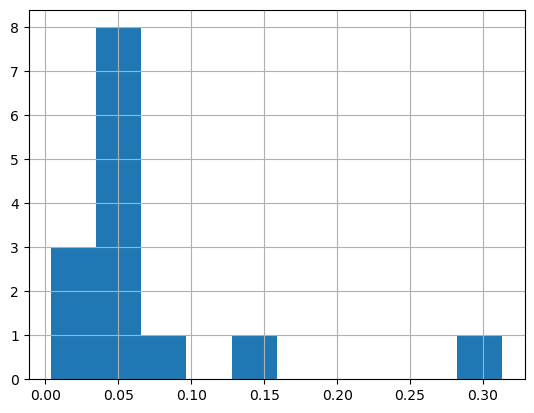

In [170]:
print(selected_feat)
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

<Figure size 640x480 with 0 Axes>

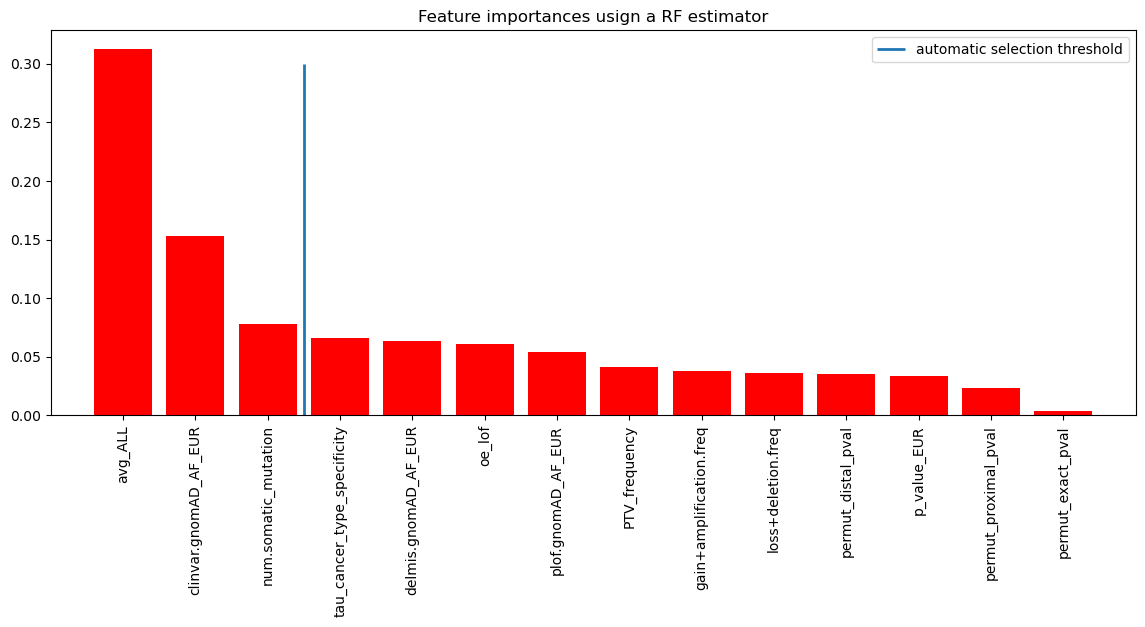

In [172]:
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
# X is the train data used to fit the model 
plt.figure()
plt.figure(figsize=(14,5))
plt.title("Feature importances usign a RF estimator")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), X_train.columns[indices], rotation='vertical')
#plt.xticks(X_train.columns[indices], indices)
plt.xlim([-1, X.shape[1]])
plt.vlines(x=2.5, ymin = 0, ymax = 0.3, linewidth = 2, label="automatic selection threshold")
plt.legend()

# plt.savefig('/home/amaqueda/TFM/ML_project/ML_part/feature_selection/plots/rf_non_redundant.pdf', format = 'pdf')
plt.show()
